# Quantum Sensing with Ramsey Measurement Protocol
This notebook computes the time-dependent transition probability of a two level system (TLS) coupled to a classical AC signal. The first part of this notebook performs this measurement in a decoherence free environment and demonstrates the use of a $\pi$ pulse to obtain a finite signal from a periodic driving field with zero time average. In the second part, we will consider the effect of decoherence through a power law decay of the transition probability. A deeper phenomenological model for decoherence will be considered in another notebook, where the TLS will be coupled to a bosonic bath and the Lindblad master equation will be used to study the dynamics. 

In this notebook we will use 1/Energy as unit for time so that $\hbar = 1$. 

## Idealized dyanmics without decoherence
In this part we will use the Hamiltonian,

$$ H(t) = \frac{1}{2} \omega_0 Z + \frac{1}{2} V(t) Z,  $$

where $X,Y,Z$ are the Pauli operators.


In [ ]:
import numpy as np
from scipy import linalg
from scipy import integrate
from math import pi, sqrt
from quantum.floquet import dynamics
from quantum.utils import plotting as PLT
from matplotlib import pyplot as plt
%matplotlib inline

def matrix_exp(a, H, hermitian=True):
    """
    Exponentiation of H by direct diagonalization
    Args:
        a (complex): scalar to multiply H by
        H (complex) : square matrix
    Keywords
        hermitian (boolean) : if true uses linalg.eigh function for diagonalization
    Returns:
        U = exp( a H) 
    """
    if hermitian:
        W, V = linalg.eigh(H)
    else:
        W, V = linalg.eig(H)
    U = V @ np.diag( np.exp( a * W) ) @ V.conj().T
    return U

def fast_matrix_exp(a,H,hermitian=True):
    """
    exp(a H) ~  (1 - a /2 H)^-1 (1 + a/2 H)
    """
    I = np.eye(H.shape[0])
    U = linalg.solve(I - a/2 * H, I + a/2 * H)
    return U

In [ ]:
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Hadamard = np.array([[1,1],[1,-1]])/np.sqrt(2.)
def Hamiltonian(Vpar, Vperp, w0 = 2*pi):
    return (w0 + Vpar)/2*Z + Vperp * X

## Test with first order perturbation theory
The first test is with $ V_\perp(t) = 0 $, and $ V_\parallel(t) = A \cos(\omega_c t) $. We define the time integral,

$$ \Phi(t) = \int_0^t dt'  V_\parallel(t'). $$

We compute the state as a function of time,

$$ \psi_{on}(t)  = \frac{1}{\sqrt{2}}\left[e^{-i \omega_0 t /2-i \Phi(t)/2  }|0> + e^{i \omega_0 t/2  + i \Phi(t)/2  }|1>\right].  $$

We consider many experiments with a POVM performed at different times after evolving the state. Before the POVM, we first apply the Hadamard gate, and then compute the projection on state $|1>$. 

$$ \hat{R}\psi_{on}(t)  = \cos\left[{\omega_0 t /2 + \Phi(t)/2  }\right]|0>  - i\sin\left[{\omega_0 t/2  + \Phi(t)/2  }\right]|1>.  $$

The probability of projection on to state $|1>$ is,

$$ p_1(t) = \sin^2\left[{\omega_0 t/2  + \Phi(t)/2  }\right]. $$

We compute these probabilities with and without the signal. In the latter case, the same formula applies with $\Phi=0$. The difference between the two probabilities is,

$$ p_1(t) - p_0(t) = \frac{1}{2}\sin(\omega_0 t)\sin(\Phi(t)) - \frac{1}{2}\cos(\omega_0 t)\left[ \cos(\Phi(t)) - 1 \right] 
$$.

For small signals, we expand this to first order in $\Phi$ and obtain a result proportional to the integral of the signal,

$$ p_1(t) - p_0(t) = \sin(\omega_0 t) \Phi (t) + O(\Phi^2). $$


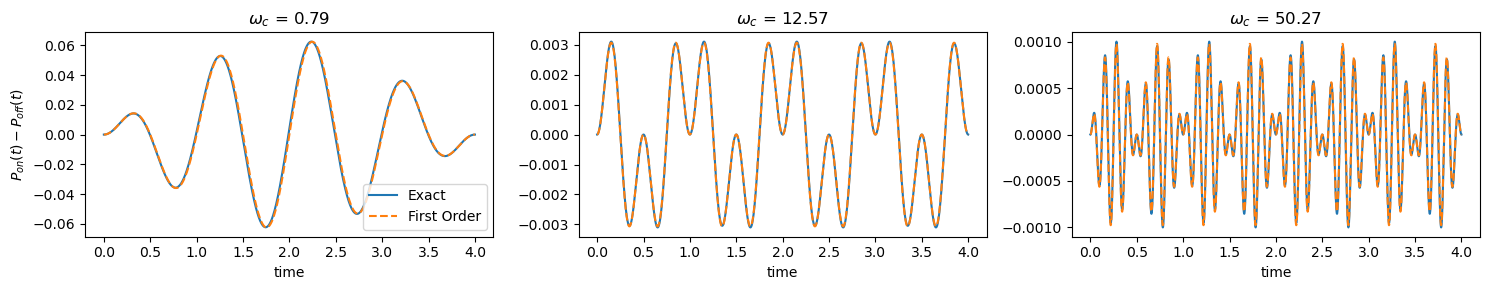

In [ ]:
w0 = 2*pi
A  = 0.1
def state(psi0,A,wc):
    U,(psi,t),_ = dynamics.propagator(4,dt=0.001, Hfunc =  lambda t : Hamiltonian( A*np.cos(wc*t) , 0, w0=w0), psi=psi0)
    psi = psi @ Hadamard
    return psi,t

def integral_Vparallel(t,A,wc):
    return 0.5*A/wc*np.sin(wc*t)

fig,axs=PLT.subplots(ncols=3,figsize=(15,3),sharex=True)
for i,wc in enumerate([pi/4,4*pi, 16*pi]):
    psin,t = state(Hadamard @ [1,0], 0, wc)
    psis,t = state(Hadamard @ [1,0], A, wc)
    
    pn = np.abs(psin[:,1])**2
    ps = np.abs(psis[:,1])**2
    
    ax=axs[i]
    ax.plot(t, ps-pn, '-', label='Exact')
    ax.plot(t, np.sin(w0 * t)*integral_Vparallel(t,A,wc),'--',label='First Order')
    ax.set_title(r'$\omega_c$ = {:.2f}'.format(wc))
axs[0].set_ylabel('$P_{on}(t)-P_{off}(t)$')
for ax in axs:
    ax.set_xlabel('time')
axs[0].legend()
fig.tight_layout()

## AC Signal with $\pi$ pulse

The first test is with $ V_\perp(t) = 0 $, and $ V_\parallel(t) = A \cos(\omega_c t) $. We define the time integral,

$$ \Phi(t) = \int_0^t dt'  V_\parallel(t'). $$

We compute the state as a function of time,

Now the state some time after is,

The probability of projection on to state $|1>$ is,

For small signals, we expand this to first order in $\Phi$ and obtain a result proportional to the integral of the signal,

$$ p_1(t) - p_0(t) = \sin(\omega_0(t-2 t_p))\left[\int_{0}^{t_p} V_\parallel(t')dt' - \int_{t_p}^t V_\parallel(t')dt'\right]. $$

In [ ]:
def signal1perp(t,A=None,PulseWidth=0.05,PulseFreq=1,n=1):
    A  = pi/2/PulseWidth if A is None else A
    TPulse = 1/PulseFreq
    if np.isscalar(t):
        for m in range(1,n+1):
            if np.abs(t-m*TPulse)<PulseWidth/2:
                return A
        return 0   
    F = np.zeros(t.shape)
    for m in range(1,n+1):
        sel = np.abs(t-m*TPulse)<PulseWidth/2
        F[sel]=A
    return F

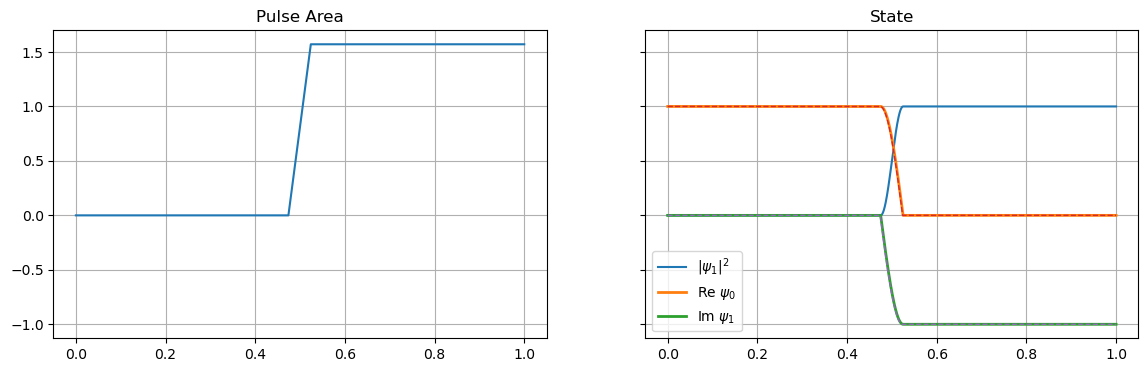

In [ ]:
psi0 = [1,0]
PulseWidth=0.05
PulseAmp=None

U,(psi,t),resid = dynamics.propagator(1.,dt=0.001, Hfunc =  lambda t : Hamiltonian( Vpar=0, Vperp=signal1perp(t,PulseFreq=2,n=1,A=PulseAmp,PulseWidth=PulseWidth) ,w0=0), psi=psi0)
p = np.abs(psi)**2
u = signal1perp(t,PulseFreq=2,n=1,A=PulseAmp,PulseWidth=PulseWidth)
v = np.cumsum(u)*(t[1]-t[0])

fig,axs=PLT.subplots(ncols=2, figsize=(14,4),sharex=True,sharey=True)
for ax in axs:
    ax.grid(True)
    ax.set_title('time')
axs[0].plot(t, v)
axs[0].set_title('Pulse Area')
ax=axs[1]
ax.plot(t, p[:,1],label=r'$|\psi_1|^2$')
ax.plot(t, psi[:,0].real,linewidth=2, label=r'Re $\psi_0$')
ax.plot(t, psi[:,1].imag,linewidth=2, label=r'Im $\psi_1$')
ax.plot(t, np.cos(v),'--',linewidth=1)
ax.plot(t, -np.sin(v),'--',linewidth=1)
axs[1].set_title('State')
ax.legend()

In [ ]:
def signal(t,SignalAmp, SignalFreq):
    return SignalAmp*np.sin(SignalFreq*2*pi*t)

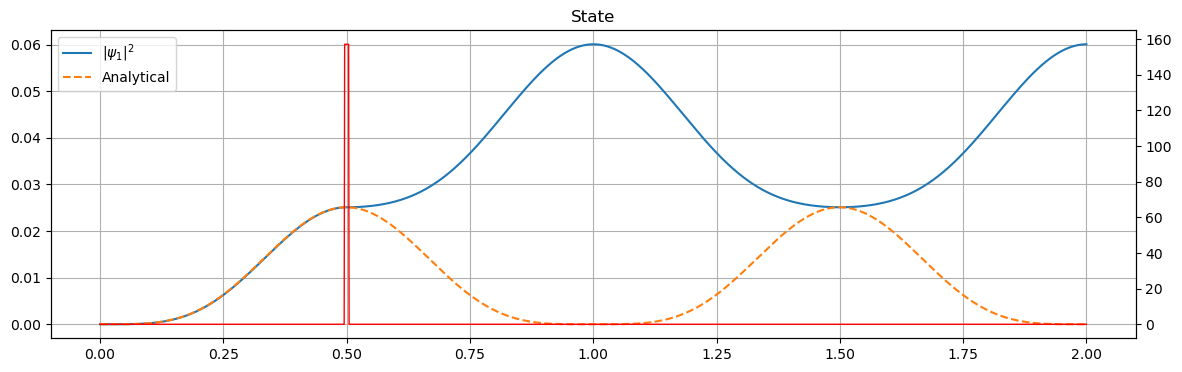

In [ ]:
def state(psi0,SignalAmp,SignalFreq, PulseAmp, tpulse):
    U,(psi,t),resid = dynamics.propagator(2.,dt=0.001, 
                                          Hfunc =  lambda t : Hamiltonian(Vpar =  signal(t,SignalAmp,SignalFreq), 
                                                                          Vperp = signal1perp(t,PulseFreq=2,A=PulseAmp,PulseWidth=PulseWidth),w0=0*pi), 
                                          psi=psi0)
    psi = psi @ Hadamard
    return psi,t

psi0 = [1,0]
psi1 = Hadamard @ psi0
PulseWidth=0.01
PulseAmp = pi/2/PulseWidth
tpulse = 0.5
SignalFreq = 1

psi,t = state(Hadamard @ psi0, 1, SignalFreq, 1/PulseWidth, tpulse=0.5/SignalFreq)

p = np.abs(psi)**2
u = signal(t,1,SignalFreq)/2
q = signal1perp(t,PulseFreq=2,A=PulseAmp,PulseWidth = PulseWidth)
v = np.cumsum(u)*(t[1]-t[0])

fig,ax=PLT.subplots(ncols=1, figsize=(14,4),sharex=True,sharey=True)
ax.grid(True)
ax.plot(t, p[:,1], label=r'$|\psi_1|^2$')
ax.plot(t, np.sin(v)**2,'--',label='Analytical')
ax.set_title('State')
ax.legend()
ax2=ax.twinx()
ax2.plot(t, q, '-r', linewidth=1)

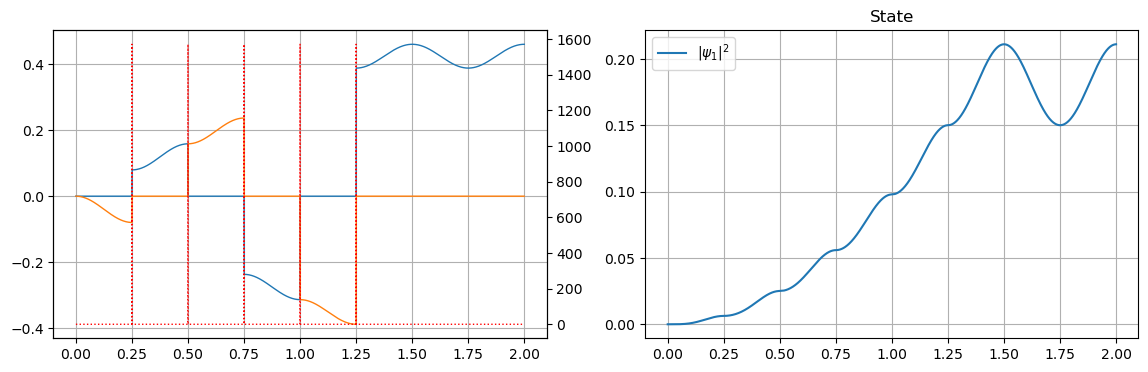

In [ ]:
PulseWidth=0.001
def state(tmax,psi0,w0,SignalAmp,SignalFreq, PulseAmp,PulseFreq):
    U,(psi,t),resid = dynamics.propagator(tmax,dt=0.001, 
                                          Hfunc =  lambda t : Hamiltonian(Vpar =  signal(t,SignalAmp,SignalFreq), 
                                                                          Vperp = signal1perp(t,A=PulseAmp,PulseWidth=PulseWidth,
                                                                                              PulseFreq=PulseFreq,n=5),w0=w0), 
                                          psi=psi0)
    psi = psi @ Hadamard
    return psi,t

psi0 = [1,0]
psi1 = Hadamard @ psi0
PulseAmp = pi/2/PulseWidth
SignalFreq = 2
PulseFreq = 2*SignalFreq

psi,t = state(2,Hadamard @ psi0, 0, 1, SignalFreq, PulseAmp, PulseFreq=PulseFreq)

p = np.abs(psi)**2
u = signal(t,1,SignalFreq)/2
q = signal1perp(t,A=PulseAmp,PulseWidth = PulseWidth,PulseFreq=PulseFreq,n=5)
v = np.cumsum(u)*(t[1]-t[0])

fig,axs=PLT.subplots(ncols=2, figsize=(14,4),sharex=True,sharey=False)
for ax in axs:
    ax.grid(True)

S  = lambda t : (np.cos(2*pi*t)-1)/4/pi    
ax=axs[0]
ax.plot(t, psi[:,1].real,t, psi[:,1].imag,linewidth=1) 

ax=axs[1]
ax.plot(t, p[:,1], label=r'$|\psi_1|^2$')
ax.set_title('State')
ax.legend()
ax2=axs[0].twinx()
#ax2.plot(t, u, ':b')
ax2.plot(t, q, ':r',linewidth=1)

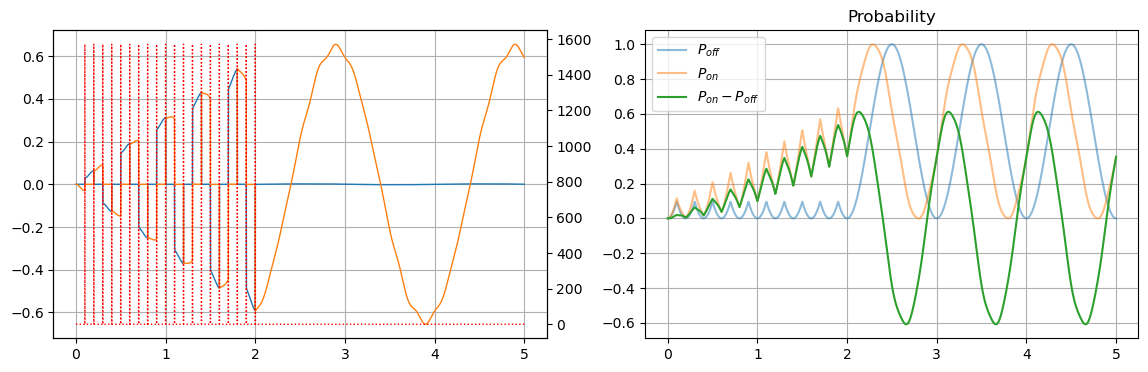

In [78]:
SignalFreq = 5

PulseWidth=0.001
npulses = 20
PulseAmp = pi/2/PulseWidth
PulseFreq = 2*SignalFreq

def state(tmax,psi0,w0,SignalAmp,SignalFreq, PulseAmp,PulseFreq):
    U,(psi,t),resid = dynamics.propagator(tmax,dt=0.001, 
                                          Hfunc =  lambda t : Hamiltonian(Vpar =  signal(t,SignalAmp,SignalFreq), 
                                                                          Vperp = signal1perp(t,A=PulseAmp,PulseWidth=PulseWidth,
                                                                                              PulseFreq=PulseFreq,n=npulses),w0=w0), 
                                          psi=psi0)
    psi = psi @ Hadamard
    return psi,t

psi0 = [1,0]
psi1 = Hadamard @ psi0

psiref,t = state(5,Hadamard @ psi0, 2*pi, 0, SignalFreq, PulseAmp, PulseFreq=PulseFreq)
psisig,t = state(5,Hadamard @ psi0, 2*pi, 1, SignalFreq, PulseAmp, PulseFreq=PulseFreq)


pref = np.abs(psiref)**2
psig = np.abs(psisig)**2

p = psig - pref
psi = psisig - psiref

q = signal1perp(t,A=PulseAmp,PulseWidth = PulseWidth,PulseFreq=PulseFreq,n=npulses)

fig,axs=PLT.subplots(ncols=2, figsize=(14,4),sharex=True,sharey=False)
for ax in axs:
    ax.grid(True)

S  = lambda t : (np.cos(2*pi*t)-1)/4/pi    
ax=axs[0]
ax.plot(t, psi[:,1].real,t, psi[:,1].imag,linewidth=1) 

ax=axs[1]
ax.plot(t, pref[:,1], label=r'$P_{off}$',alpha=0.5,linestyle='-')
ax.plot(t, psig[:,1], label=r'$P_{on}$',alpha=0.5,linestyle='-')
ax.plot(t, p[:,1], label=r'$P_{on}-P_{off}$')
ax.set_title('Probability')
ax.legend()
ax2=axs[0].twinx()
#ax2.plot(t, u, ':b')
ax2.plot(t, q, ':r',linewidth=1)

100%|███████████████████████████████████████████| 30/30 [00:22<00:00,  1.32it/s]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

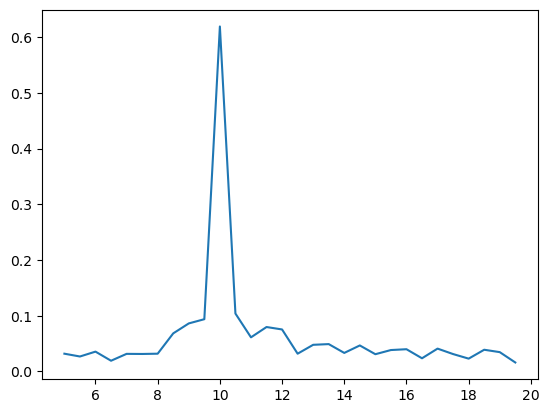

In [75]:
data=[]
for f in tqdm(np.arange(1,4,0.1)*SignalFreq):
    psiref,t = state(5,Hadamard @ psi0, pi, 0, SignalFreq, PulseAmp, PulseFreq=f)
    psisig,t = state(5,Hadamard @ psi0, pi, 1, SignalFreq, PulseAmp, PulseFreq=f)
    pref = np.abs(psiref)**2
    psig = np.abs(psisig)**2
    p = psig - pref
    data += [(f, np.abs(p).max())]
data = np.array(data)
PLT.genplot(data[:,0], data[:,1])